# LSTM
Try LSTM(4) with Integer K-mers, Embedding, Mask Zero, and Return Sequences = False.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-12 00:18:47.764755
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
EPOCHS=10
FOLDS=5  
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-12-12 00:20:02.398268
Num RCI: 3327
[('ENSG00000099869', 1.0), ('ENSG00000116652', 1.65208), ('ENSG00000117242', -0.793877)]


In [7]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3}
    length = len(rna)
    vec=[]
    for i in range(length-K+1):
        value = 0
        for j in range(K):
            value *= 4   
            nextnuc = rna[i+j]
            if nextnuc=='N':
                value = -1   # indicate an N
                break
            nucval = VALS[nextnuc]
            value += nucval
        value += 1   # NNN => 0, AAA => 1
        vec.append(value)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[1, 1]
[20, 16]
[63, 57]
[64, 0]


In [8]:
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-12-12 00:20:05.418014
Load sequence
2022-12-12 00:20:29.490594
Num IDs: 8564
Num labels: 8564
Num counts: 8564


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [10]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # To do: try with and without masking layer
    # To do: try the embedding layer with mask, instead of masking layer
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, K))
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, 1))
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = LSTM(4, return_sequences=False) # True)
    # rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    # dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    # dropout1_layer = Dropout(0.50)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    #rnn.add(dense1_layer)
    #rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [11]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-12 00:20:29.535633
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 16)          4112      
                                                                 
 lstm (LSTM)                 (None, 4)                 336       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 4,453
Trainable params: 4,453
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        print('Training example')
        print(X_train[0])
        
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
        if BREAK:
            break
        
    print()
    return cv_scores
print(datetime.now())

2022-12-12 00:20:33.306947


2022-12-12 00:20:33.316448
2022-12-12 00:20:33.316550
splitting
Fold 1
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (6777, 3997) (6777, 1)
Valid sizes (1787, 3997) (1787, 1)
Train set ones/size 2754 / 6777
Valid set ones/size 765 / 1787
BUILD MODEL
COMPILE
FIT
2022-12-12 00:20:36.084288
Epoch 1/10
212/212 [==============================] - 32s 112ms/step - loss: 0.6724 - accuracy: 0.5950 - val_loss: 0.6850 - val_accuracy: 0.5725
Epoch 2/10
212/212 [==============================] - 24s 112ms/step - loss: 0.6413 - accuracy: 0.6333 - val_loss: 0.7142 - val_accuracy: 0.5881
Epoch 3/10
212/212 [==============================] - 23s 108ms/step - loss: 0.6242 - accuracy: 0.6633 - val_loss: 0.7363 - val_accuracy: 0.5658
Epoch 4/10
212/212 [==============================] - 23s 108ms/step - loss: 0.6145 - accuracy: 0.6683 - val_loss: 0.7435 - val_accuracy: 0.5786
Epoch 5/10
212/212 [==============================] - 23s 109ms/step - loss: 0.6073 - accuracy: 0.6841 - val_loss: 0.7

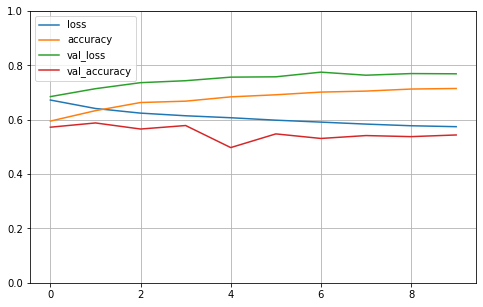

Compute valiation accuracy
2022-12-12 00:25:01.994307
accuracy: 54.39%
2022-12-12 00:25:04.544589
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (6893, 3997) (6893, 1)
Valid sizes (1671, 3997) (1671, 1)
Train set ones/size 2899 / 6893
Valid set ones/size 620 / 1671
BUILD MODEL
COMPILE
FIT
2022-12-12 00:25:07.192894
Epoch 1/10
216/216 [==============================] - 28s 111ms/step - loss: 0.6762 - accuracy: 0.5823 - val_loss: 0.6601 - val_accuracy: 0.6296
Epoch 2/10
216/216 [==============================] - 23s 107ms/step - loss: 0.6429 - accuracy: 0.6292 - val_loss: 0.6655 - val_accuracy: 0.5787
Epoch 3/10
216/216 [==============================] - 23s 107ms/step - loss: 0.6188 - accuracy: 0.6633 - val_loss: 0.6735 - val_accuracy: 0.5745
Epoch 4/10
216/216 [==============================] - 24s 112ms/step - loss: 0.6062 - accuracy: 0.6739 - val_loss: 0.6782 - val_accuracy: 0.5661
Epoch 5/10
216/216 [==============================] - 23s 108ms/step - loss: 0.5908 

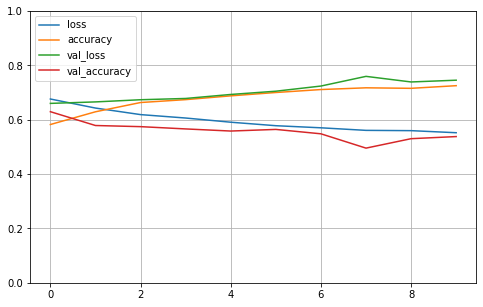

Compute valiation accuracy
2022-12-12 00:29:04.499398
accuracy: 53.80%
2022-12-12 00:29:06.905531
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (7029, 3997) (7029, 1)
Valid sizes (1535, 3997) (1535, 1)
Train set ones/size 2994 / 7029
Valid set ones/size 525 / 1535
BUILD MODEL
COMPILE
FIT
2022-12-12 00:29:11.052978
Epoch 1/10
220/220 [==============================] - 28s 110ms/step - loss: 0.6750 - accuracy: 0.5792 - val_loss: 0.6437 - val_accuracy: 0.6528
Epoch 2/10
220/220 [==============================] - 23s 106ms/step - loss: 0.6450 - accuracy: 0.6217 - val_loss: 0.6529 - val_accuracy: 0.6280
Epoch 3/10
220/220 [==============================] - 23s 106ms/step - loss: 0.6282 - accuracy: 0.6398 - val_loss: 0.6683 - val_accuracy: 0.5746
Epoch 4/10
220/220 [==============================] - 23s 107ms/step - loss: 0.6143 - accuracy: 0.6587 - val_loss: 0.6550 - val_accuracy: 0.6221
Epoch 5/10
220/220 [==============================] - 23s 107ms/step - loss: 0.6012 

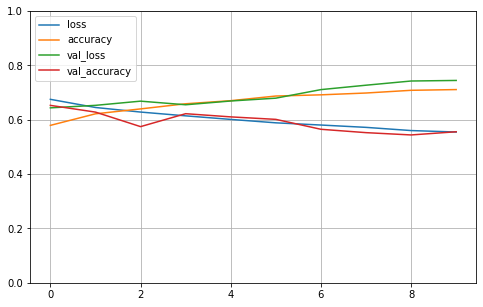

Compute valiation accuracy
2022-12-12 00:33:13.384101
accuracy: 55.57%
2022-12-12 00:33:15.581147
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (6732, 3997) (6732, 1)
Valid sizes (1832, 3997) (1832, 1)
Train set ones/size 2666 / 6732
Valid set ones/size 853 / 1832
BUILD MODEL
COMPILE
FIT
2022-12-12 00:33:18.908189
Epoch 1/10
211/211 [==============================] - 28s 116ms/step - loss: 0.6615 - accuracy: 0.6108 - val_loss: 0.6941 - val_accuracy: 0.5360
Epoch 2/10
211/211 [==============================] - 23s 111ms/step - loss: 0.6270 - accuracy: 0.6523 - val_loss: 0.6949 - val_accuracy: 0.5573
Epoch 3/10
211/211 [==============================] - 25s 117ms/step - loss: 0.6104 - accuracy: 0.6781 - val_loss: 0.7090 - val_accuracy: 0.5622
Epoch 4/10
211/211 [==============================] - 23s 111ms/step - loss: 0.5950 - accuracy: 0.6901 - val_loss: 0.7244 - val_accuracy: 0.5540
Epoch 5/10
211/211 [==============================] - 23s 111ms/step - loss: 0.5837 

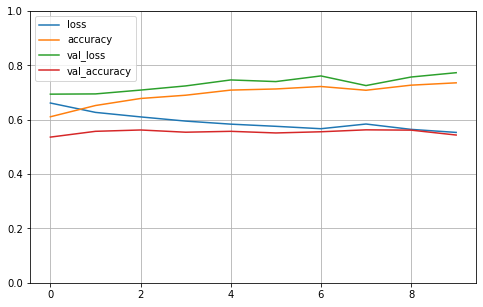

Compute valiation accuracy
2022-12-12 00:37:21.285829
accuracy: 54.37%
2022-12-12 00:37:23.962053
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (6825, 3997) (6825, 1)
Valid sizes (1739, 3997) (1739, 1)
Train set ones/size 2763 / 6825
Valid set ones/size 756 / 1739
BUILD MODEL
COMPILE
FIT
2022-12-12 00:37:26.651896
Epoch 1/10
214/214 [==============================] - 29s 117ms/step - loss: 0.6662 - accuracy: 0.6015 - val_loss: 0.6873 - val_accuracy: 0.5584
Epoch 2/10
214/214 [==============================] - 23s 110ms/step - loss: 0.6323 - accuracy: 0.6435 - val_loss: 0.6961 - val_accuracy: 0.5377
Epoch 3/10
214/214 [==============================] - 24s 111ms/step - loss: 0.6141 - accuracy: 0.6675 - val_loss: 0.7122 - val_accuracy: 0.5555
Epoch 4/10
214/214 [==============================] - 24s 110ms/step - loss: 0.6047 - accuracy: 0.6731 - val_loss: 0.7259 - val_accuracy: 0.5377
Epoch 5/10
214/214 [==============================] - 24s 110ms/step - loss: 0.6012 

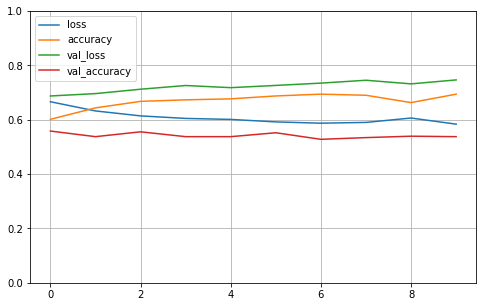

Compute valiation accuracy
2022-12-12 00:41:31.249365
accuracy: 53.77%
2022-12-12 00:41:33.783528

Cross validation acc mean 54.38% (+/- 0.65%)
2022-12-12 00:41:33.785688


In [13]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())